In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, BatchNormalization, Layer
from tensorflow.keras.regularizers import l2
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional

# Load your dataset
data = pd.read_csv("B:/Projects/PycharmProjects/PPMI_Research_on_Parkinson's/src/mahbub/finalDatasetWithUPDRSScore.csv")

# Define non-feature, numerical, and categorical columns
non_feature_columns = ['Patient ID', 'Visit Date', 'UPDRS_SCORE', 'Visit', 'Visit_int']
numerical_features = [
    'Area', 'Circularity', 'ConvexArea', 'EquivDiameter', 'Extent',
    'FilledArea', 'Kurtosis', 'Major axis length', 'Mean',
    'Minor axis length', 'PA_ratio', 'Shannon_Entropy', 'Skewness',
    'Solidity', 'Standard Deviation', 'brightness', 'contrast',
    'correlation', 'dissimilarity', 'energy', 'gabor_energy',
    'gabor_entropy', 'homogeneity', 'lbp_energy', 'lbp_entropy',
    'DATSCAN_CAUDATE_R', 'DATSCAN_CAUDATE_L', 'DATSCAN_PUTAMEN_R',
    'DATSCAN_PUTAMEN_L', 'DATSCAN_PUTAMEN_R_ANT', 'DATSCAN_PUTAMEN_L_ANT'
]
categorical_features = [
    'NP1ANXS', 'NP1APAT', 'NP1COG', 'NP1DDS', 'NP1DPRS',
    'NP1HALL', 'NP1CNST', 'NP1FATG', 'NP1LTHD', 'NP1PAIN', 'NP1SLPD',
    'NP1SLPN', 'NP1URIN', 'NP2DRES', 'NP2EAT', 'NP2FREZ', 'NP2HOBB',
    'NP2HWRT', 'NP2HYGN', 'NP2RISE', 'NP2SALV', 'NP2SPCH', 'NP2SWAL',
    'NP2TRMR', 'NP2TURN', 'NP2WALK', 'NP3BRADY', 'NP3FACXP', 'NP3FRZGT',
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML',
    'NP3KTRMR', 'NP3LGAGL', 'NP3LGAGR', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR',
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'NP3RIGLU', 'NP3RIGN',
    'NP3RIGRL', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU',
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR',
    'NHY'
]
target_column = "Disease_Severity"

# Scale numerical features
scaler = MinMaxScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# One-hot encode the target variable (Disease_Severity)
data = pd.get_dummies(data, columns=[target_column], drop_first=False)

# Extract target columns after one-hot encoding
target_columns = list(data.filter(regex='Disease_Severity').columns)

# Function to create sequences
def create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns):
    sequences = []
    targets = []
    grouped = data.groupby('Patient ID')

    for patient_id, group in grouped:
        # Drop non-feature columns
        group = group.drop(non_feature_columns, axis=1)
        
        # Select numerical and categorical features
        patient_data = group[numerical_features + categorical_features].values
        num_visits = len(patient_data)
        
        # Ensure exactly 4 visits per patient
        if num_visits >= 4:
            sequences.append(patient_data[-4:])
        else:
            # Pad with zeros if fewer than 4 visits
            padding = np.zeros((4 - num_visits, len(numerical_features + categorical_features)))
            padded_sequence = np.concatenate([padding, patient_data])
            sequences.append(padded_sequence)
        
        # Get the target sequence (last visit class one-hot encoded)
        target = group[target_columns].values[-1]
        targets.append(target)

    # Convert lists to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)
    
    return sequences, targets

# Create sequences
sequences, targets = create_sequences(data, non_feature_columns, numerical_features, categorical_features, target_columns)

# Convert sequences and targets to numpy arrays
X = np.array(sequences)
y = np.array(targets)

# Reshape X to match LSTM input shape (batch_size, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a custom attention layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],),
                                 initializer='random_normal', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        attention_weights = tf.keras.backend.sum(a, axis=1)  # Sum of attention weights for visualization
        return tf.keras.backend.sum(output, axis=1), attention_weights

# Function to create a more complex LSTM model with attention
def create_complex_lstm_with_attention(input_shape, output_shape, units=50, dropout_rate=0.5, l2_rate=0.001):
    inputs = Input(shape=input_shape)
    
    # First LSTM layer with Batch Normalization
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Second bidirectional LSTM layer with Batch Normalization
    x = Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate)))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Third LSTM layer without return_sequences
    x = LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_rate))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    # Attention layer
    x, attention_weights = AttentionLayer()(x)
    
    # Dense output layer
    outputs = Dense(output_shape, activation='softmax', kernel_regularizer=l2(l2_rate))(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Wrap Keras model for use with scikit-learn
input_shape = (X_train.shape[1], X_train.shape[2])
output_shape = y_train.shape[1]

model = KerasClassifier(model=create_complex_lstm_with_attention, input_shape=input_shape, output_shape=output_shape, verbose=0)

# Define hyperparameters for GridSearchCV
param_grid = {
    'model__units': [50, 100, 150],
    'model__dropout_rate': [0.2, 0.5],
    'model__l2_rate': [0.001, 0.01],
    'epochs': [50, 100],
    'batch_size': [32, 64]
}

# Create StratifiedKFold cross-validation object
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Helper function to stratify by multilabel target
def multilabel_stratified_kfold(X, y, skf):
    stratify_labels = np.array([''.join(str(int(class_)) for class_ in row) for row in y])
    for train_idx, test_idx in skf.split(X, stratify_labels):
        yield train_idx, test_idx

# Perform GridSearchCV with StratifiedKFold
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=list(multilabel_stratified_kfold(X, y, skf)))
grid_result = grid.fit(X, y)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params'] 
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

# Evaluate the best model
best_model = grid_result.best_estimator_.model_

# Evaluate on training data
train_loss, train_acc = best_model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_acc:.4f}  Training Loss: {train_loss:.4f}")


# Evaluate on testing data
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Testing Accuracy: {test_acc:.4f}  Testing Loss: {test_loss:.4f}")

# Predict using the best model
y_pred = best_model.predict(X_test)

# Extract attention weights from the model
# attention_layer = best_model.model.layers[-2]  # Access layers directly from best_model
# get_attention_weights = tf.keras.backend.function([best_model.model.input], [attention_layer.output[1]])
# 
# # Calculate attention weights for test data
# attention_weights = get_attention_weights([X_test])[0]
# 
# # Visualize or analyze attention weights as needed
# print("Attention Weights for the first sample in the test set:")
# print(attention_weights[0])  # Replace 0 with index if you want to see attention weights for a specific sample


Best: 0.521930 using {'batch_size': 64, 'epochs': 100, 'model__dropout_rate': 0.5, 'model__l2_rate': 0.01, 'model__units': 50}
0.447368 (0.018608) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 50}
0.460526 (0.018608) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 100}
0.456140 (0.012405) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 150}
0.434211 (0.042974) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 50}
0.451754 (0.061089) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 100}
0.412281 (0.016411) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 150}
0.478070 (0.006203) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate'

Best: 0.521930 using {'batch_size': 64, 'epochs': 100, 'model__dropout_rate': 0.5, 'model__l2_rate': 0.01, 'model__units': 50}
0.447368 (0.018608) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 50}
0.460526 (0.018608) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 100}
0.456140 (0.012405) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.001, 'model__units': 150}
0.434211 (0.042974) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 50}
0.451754 (0.061089) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 100}
0.412281 (0.016411) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate': 0.2, 'model__l2_rate': 0.01, 'model__units': 150}
0.478070 (0.006203) with: {'batch_size': 32, 'epochs': 50, 'model__dropout_rate'

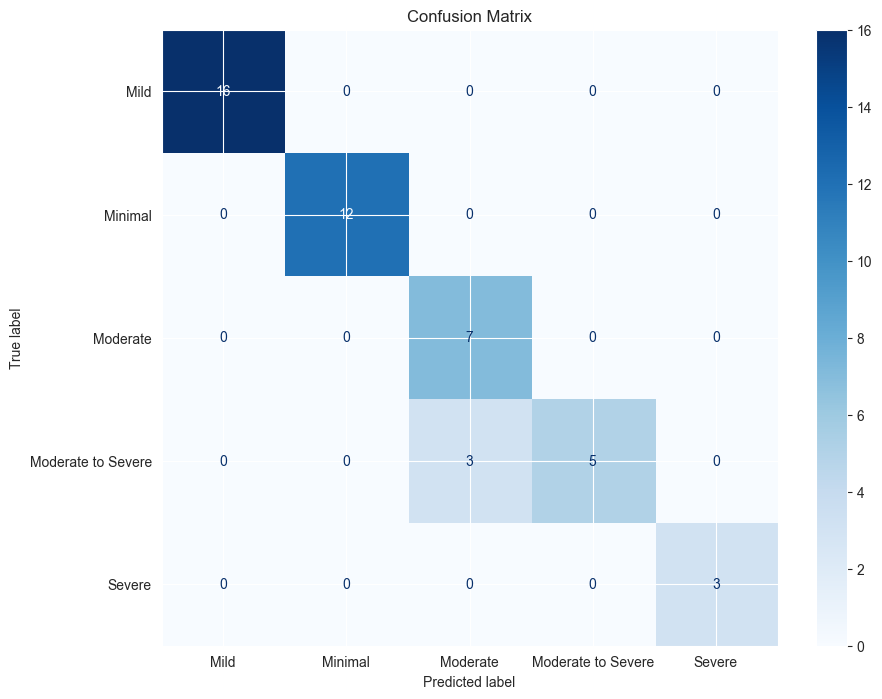

Classification Report:
                    precision    recall  f1-score   support

              Mild       1.00      1.00      1.00        16
           Minimal       1.00      1.00      1.00        12
          Moderate       0.70      1.00      0.82         7
Moderate to Severe       1.00      0.62      0.77         8
            Severe       1.00      1.00      1.00         3

          accuracy                           0.93        46
         macro avg       0.94      0.93      0.92        46
      weighted avg       0.95      0.93      0.93        46
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
Attention Weights for the first sample in the test set:
[1.         1.         1.         1.         1.         1.
 1.         0.9999999  1.         1.0000001  1.         1.
 1.         0.9999999  0.99999994 1.         1.         0.9999999
 1.         0.99999994 1.         0.99999994 1.         1.
 1.         0.99999994 1.         1.         1.0000001  1.
 1.         1.         0.99999994 1.  

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.models import Model

# Print the best parameters and score from GridSearchCV
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

# Evaluate the best model
best_model = grid_result.best_estimator_.model_

# Evaluate on training data
train_loss, train_acc = best_model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_acc:.4f}  Training Loss: {train_loss:.4f}")

# Evaluate on testing data
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Testing Accuracy: {test_acc:.4f}  Testing Loss: {test_loss:.4f}")

# Predict using the best model
y_pred = best_model.predict(X_test)

# Convert predictions from one-hot encoding to class labels
y_test_classes = y_test.argmax(axis=1)
y_pred_classes = y_pred.argmax(axis=1)

# Define the class labels with the prefix removed
target_columns = list(data.filter(regex='Disease_Severity').columns)
cleaned_labels = [label.replace('Disease_Severity_', '') for label in target_columns]

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Increase the size of the confusion matrix plot
plt.figure(figsize=(10, 8))  # Adjust the figure size here (width=10, height=8)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=cleaned_labels[:len(set(y_test_classes))])
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=cleaned_labels[:len(set(y_test_classes))]))

# Extract attention weights from the model
attention_layer = best_model.get_layer(name='attention_layer_144')  # Ensure the name matches your AttentionLayer definition
attention_model = Model(inputs=best_model.input, outputs=attention_layer.output[1])
attention_weights = attention_model.predict(X_test)

# Visualize or analyze attention weights as needed
print("Attention Weights for the first sample in the test set:")
print(attention_weights[2])  # Replace 2 with index if you want to see attention weights for a specific sample


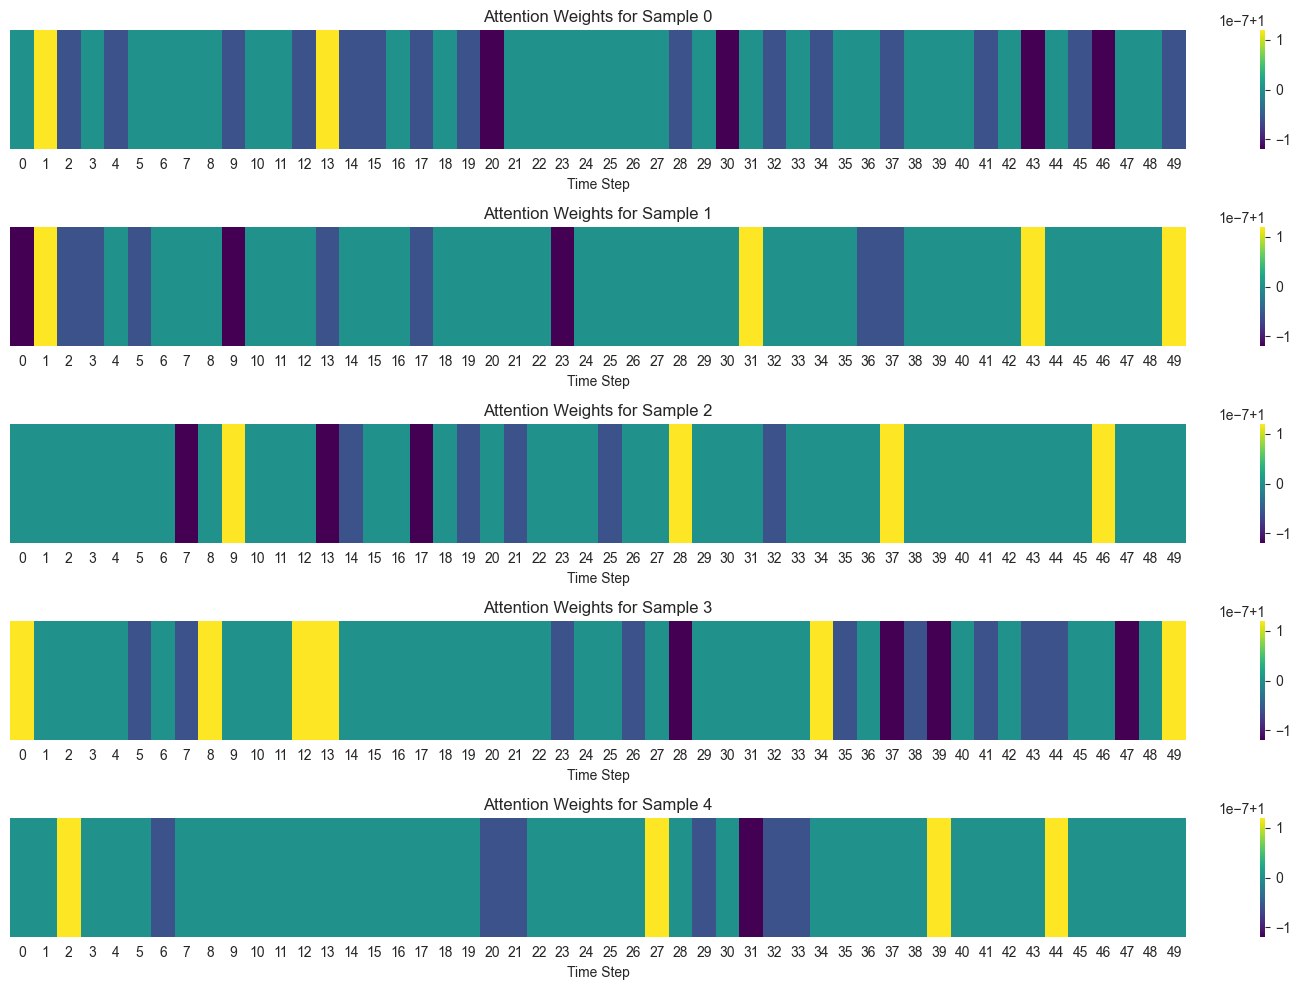

In [3]:
import numpy as np
import seaborn as sns

# Function to plot attention weights
def plot_attention_weights(attention_weights, sample_index, ax):
    sns.heatmap(np.expand_dims(attention_weights[sample_index], axis=0), cmap="viridis", cbar=True, ax=ax)
    ax.set_title(f'Attention Weights for Sample {sample_index}')
    ax.set_xlabel('Time Step')
    ax.set_yticks([])

# Plot attention weights for the first 5 samples
fig, axs = plt.subplots(5, 1, figsize=(15, 10))
for i in range(5):
    plot_attention_weights(attention_weights, i, axs[i])
plt.tight_layout()
plt.show()